In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import supervision as sv

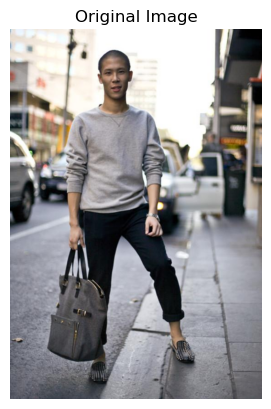

In [8]:
# Set directories
DATA_DIR = "../data/outfits/positive"
PERSON_DIR = "../data/segmented_person"
ITEMS_DIR = "../data/segmented_items"
folders = [DATA_DIR, PERSON_DIR, ITEMS_DIR]

# Create the folders
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Load first image for debugging
image_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise ValueError("No images found in the directory!")
image_path = os.path.join(DATA_DIR, image_files[100])  # Take the first image
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise ValueError(f"Failed to load image: {image_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

# Display original image
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

I0000 00:00:1741270612.813855 1667248 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3
W0000 00:00:1741270612.880043 1668788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741270612.900417 1668792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


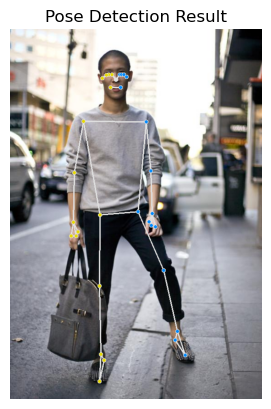

In [9]:
# ---- STEP 1: POSE ESTIMATION ----
# https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/pose_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Pose_Landmarker.ipynb#scrollTo=tzXuqyIBlXer

base_options = python.BaseOptions(model_asset_path='../models/pose_landmarker_full.task')
options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
detection_result = detector.detect(mp_image)
if not detection_result.pose_landmarks:
    raise ValueError("Pose estimation failed!")

# Draw pose landmarks
annotated_image = draw_landmarks_on_image(image_rgb, detection_result)
plt.imshow(annotated_image)
plt.title("Pose Detection Result")
plt.axis("off")
plt.show()

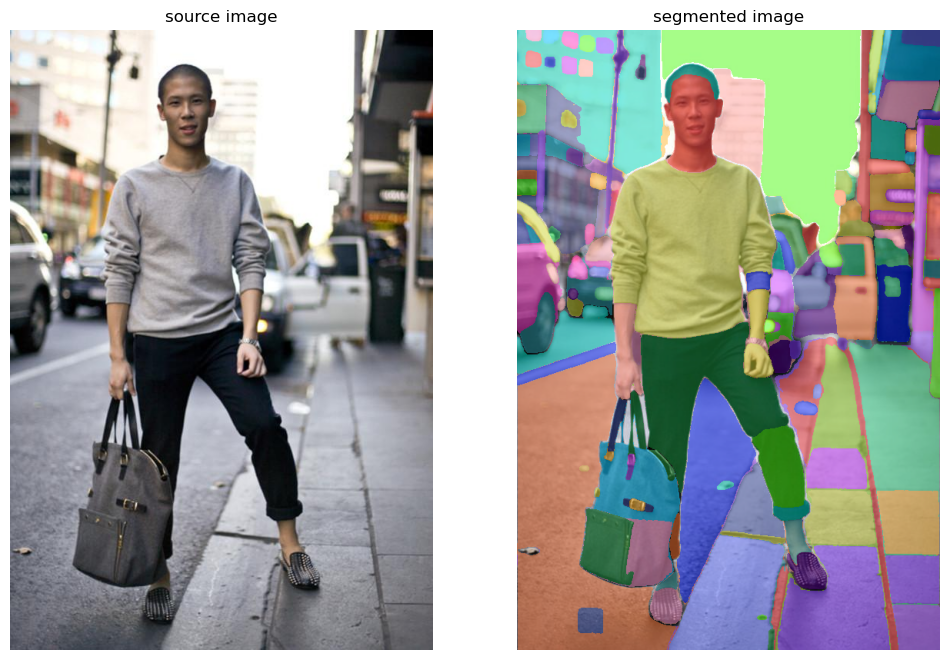

In [10]:
# ---- STEP 2: PERSON SEGMENTATION USING SAM ----
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "../models/sam_vit_h.pth"

# load SAM model with vit_h encoder (636M parameters)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.56,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)
sam_result = mask_generator.generate(image_rgb)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

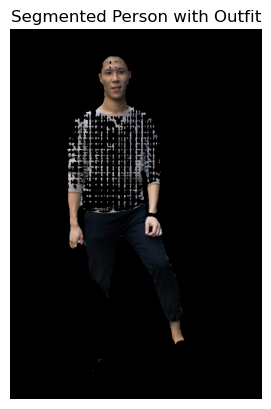

In [13]:
# ---- STEP 3: FILTER MASK FOR THE PERSON AND EXTRACT ----

def get_pose_keypoints(pose_landmarks):
    """Extract key points for filtering the person's mask."""
    keypoints = {}
    for idx, lm in enumerate(pose_landmarks):
        keypoints[idx] = (int(lm.x * image_rgb.shape[1]), int(lm.y * image_rgb.shape[0]))
    return keypoints

# Get pose keypoints
pose_keypoints = get_pose_keypoints(detection_result.pose_landmarks[0])

# Define a bounding box around the person using pose keypoints
x_min = min([kp[0] for kp in pose_keypoints.values()])
y_min = min([kp[1] for kp in pose_keypoints.values()])
x_max = max([kp[0] for kp in pose_keypoints.values()])
y_max = max([kp[1] for kp in pose_keypoints.values()])

person_bbox = np.array([[x_min, y_min, x_max, y_max]])

# Predict masks for the person using SAM
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)
masks, _, _ = predictor.predict(box=person_bbox, multimask_output=False)

# Convert mask to binary format
binary_mask = masks[0].astype(np.uint8) * 255

# Apply the mask to extract the person
person_segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

# Display the segmented person
plt.imshow(person_segmented)
plt.title("Segmented Person with Outfit")
plt.axis("off")
plt.show()

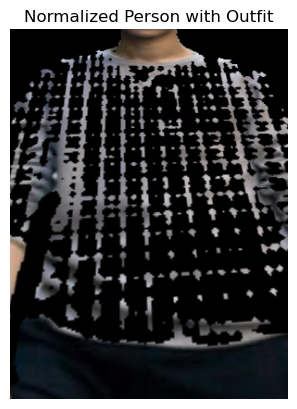

Normalized person saved at: ../data/segmented_person/normalized_person_2024.jpg


In [14]:
# ---- STEP 4: NORMALIZE THE IMAGE ----

# Perspective correction (optional but recommended for normalization)
if all(k in pose_keypoints for k in [11, 12, 23, 24]):  # Shoulders and hips
    src_pts = np.array([
        pose_keypoints[11],  # Left shoulder
        pose_keypoints[12],  # Right shoulder
        pose_keypoints[23],  # Left hip
        pose_keypoints[24]   # Right hip
    ], dtype=np.float32)

    dst_pts = np.array([
        [50, 50],            # Top-left
        [250, 50],           # Top-right
        [50, 350],           # Bottom-left
        [250, 350]           # Bottom-right
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    normalized_person = cv2.warpPerspective(person_segmented, M, (300, 400))

    # Display the normalized person
    plt.imshow(normalized_person)
    plt.title("Normalized Person with Outfit")
    plt.axis("off")
    plt.show()
else:
    print("Keypoints for perspective correction missing. Skipping normalization.")

# Resize the image to a standard size (e.g., 256x256)
normalized_person_resized = cv2.resize(normalized_person, (256, 256), interpolation=cv2.INTER_LINEAR)

# Save the normalized person image
normalized_person_path = os.path.join(PERSON_DIR, f"normalized_person_{os.path.basename(image_path)}")
cv2.imwrite(normalized_person_path, cv2.cvtColor(normalized_person_resized, cv2.COLOR_RGB2BGR))

print(f"Normalized person saved at: {normalized_person_path}")

In [ ]:
# WeirdOutfitStyle
from datasets import load_dataset
ds = load_dataset("Norod78/WeirdOutfitStyle")

In [ ]:
# Office Outfit Train Data
import kagglehub
path = kagglehub.dataset_download("jubeena/office-outfit-train-outfits")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("llkdev/fashionstyle")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("khizerraza/men-vs-women-images-dataset")
print("Path to dataset files:", path)